In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
import mlflow
import mlflow.sklearn

In [3]:
features_df = pd.read_csv('../data/processed/features.csv')

In [4]:
from sklearn.preprocessing import LabelEncoder
X = features_df.drop('label', axis=1).values  # features
y = features_df['label'].values  # target variable
le = LabelEncoder()
y = le.fit_transform(y)
X.shape, y.shape

((17579, 24), (17579,))

In [5]:


# Define the pipeline that includes scaling and the classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

# Parameters to search
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='accuracy')

# MLflow experiment setup
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("ECG_Heart_Rhythm_Classification_RF")

# Start MLflow run
with mlflow.start_run(run_name="Random Forest"):
    # Execute the grid search
    grid_search.fit(X, y)

    # Best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Perform KFold cross-validation
    cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='accuracy')
    
    # Log parameters and metrics
    mlflow.log_params(best_params)
    mlflow.log_metric("cv_accuracy_mean", cv_scores.mean())
    mlflow.log_metric("cv_accuracy_std", cv_scores.std())
    
    # Log the best model
    mlflow.sklearn.log_model(best_model, "model")

    print(f"Best Parameters: {best_params}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


2024/02/28 16:22:05 INFO mlflow.tracking.fluent: Experiment with name 'ECG_Heart_Rhythm_Classification_RF' does not exist. Creating a new experiment.


Best Parameters: {'rf__max_depth': 30, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}
CV Accuracy: 0.7691 (+/- 0.0031)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Fit the best model on the training set
best_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=30, min_samples_split=5,
                                        n_estimators=300))])

In [8]:
# Predict the test set
y_pred = best_model.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7671


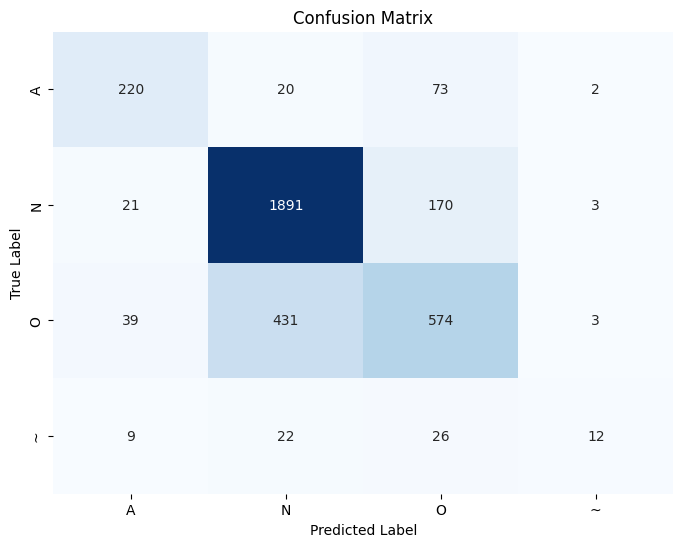

In [11]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

           A       0.76      0.70      0.73       315
           N       0.80      0.91      0.85      2085
           O       0.68      0.55      0.61      1047
           ~       0.60      0.17      0.27        69

    accuracy                           0.77      3516
   macro avg       0.71      0.58      0.61      3516
weighted avg       0.76      0.77      0.76      3516



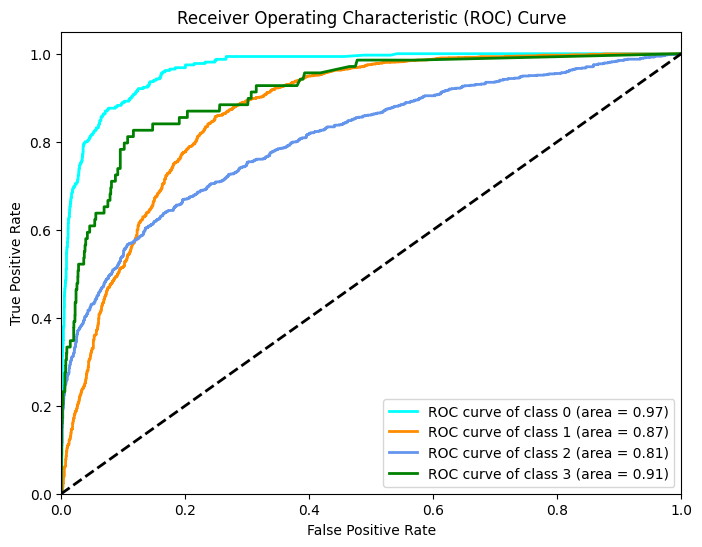

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output for the entire dataset before train-test split
y = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming best_model is a model instance from GridSearchCV or similar
classifier = OneVsRestClassifier(best_model)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
    label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Random Forest Model Performance on ECG Data

The Receiver Operating Characteristic (ROC) curves for the Random Forest model demonstrate its performance across different classes:

- **Class 0 (Atrial Fibrillation)**
  - **AUC**: 0.97
  - The model exhibits exceptional ability in detecting Atrial Fibrillation, with an AUC nearing perfection. This suggests a high sensitivity and specificity for this class.

- **Class 1 (Normal Rhythms)**
  - **AUC**: 0.87
  - The model performs robustly in identifying Normal Rhythms, indicated by a high AUC value, showcasing its strong discriminative power.

- **Class 2 (Other Rhythms)**
  - **AUC**: 0.81
  - Good predictive power is shown by the model for Other Rhythms, with a reasonably high AUC, though there is potential for enhancement.

- **Class 3 (Noise)**
  - **AUC**: 0.91
  - The model proves to be highly effective in classifying Noise, with an AUC comparable to that of Atrial Fibrillation, highlighting its ability to distinguish noisy ECG signals from other rhythm types.

In summary, the Random Forest model displays high-performance metrics, with significant predictive capabilities for each of the ECG classes under consideration.